[StackOverflow](https://stackoverflow.com/questions/28935983/preprocessing-image-for-tesseract-ocr-with-opencv)

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider

In [2]:
image_path = "../imgs/test_audi.png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)

print(image.ndim)
print(type(image))

2
<class 'numpy.ndarray'>


In [3]:
import numpy as np
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
blue = make_colormap([c("black"), c("blue")])
green = make_colormap([c("black"), c("green")])
red = make_colormap([c("black"), c("red")])

def show_splitted(img):
    splitted = cv2.split(img)
    print(len(splitted))
    plt.imshow(splitted[0], cmap=blue)
    plt.show()
    plt.imshow(splitted[1], cmap=green)
    plt.show()
    plt.imshow(splitted[2], cmap=red)
    plt.show()

3


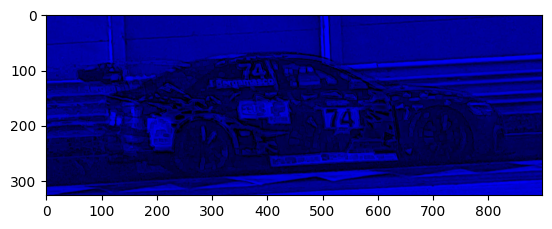

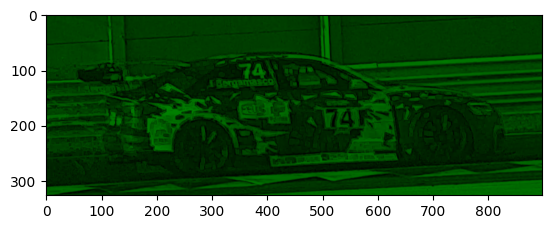

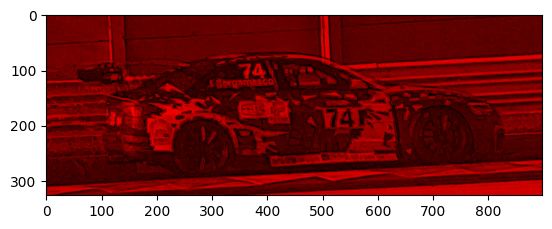

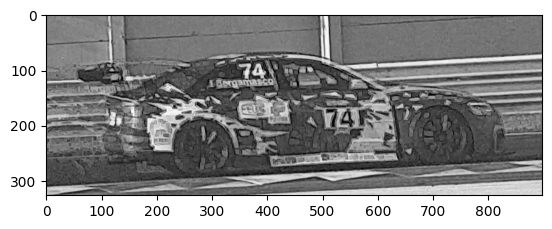

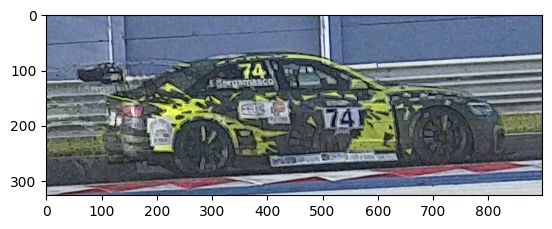

In [4]:

show_splitted(image_color)

plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
def new_thres(h1, s1, v1, h2, s2, v2):
    hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)
    lower_white = np.array([h1, s1, v1])
    upper_white = np.array([h2, s2, v2])
    print(upper_white)

    mask = cv2.inRange(hsv, lower_white, upper_white)

    plt.imshow(mask, cmap="gray")
    plt.show()

    return mask

h1 = IntSlider(min=0, max=179, value=105)
s1 = IntSlider(min=0, max=255, value=15)
v1 = IntSlider(min=0, max=255, value=190)

h2 = IntSlider(min=0, max=179, value=172)
s2 = IntSlider(min=0, max=255, value=111)
v2 = IntSlider(min=0, max=255, value=255)

interact(new_thres, h1 = h1, s1 = s1, v1 = v1, h2 = h2, s2 = s2, v2 = v2)

interactive(children=(IntSlider(value=105, description='h1', max=179), IntSlider(value=15, description='s1', m…

<function __main__.new_thres(h1, s1, v1, h2, s2, v2)>

[155  90 255]


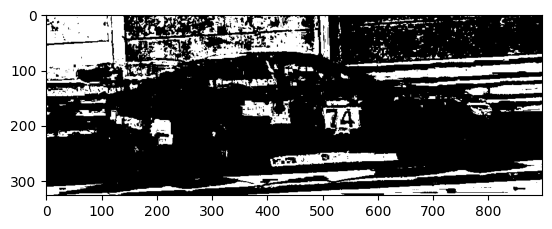

In [6]:
thres = new_thres(98, 0, 127, 155, 90, 255)

In [7]:
def calc_epsilon(e = 0.07110000000000001):
    print(e)
    contours, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    converted = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(converted, contours, -1, (255, 0, 0), 3)

    approxed = []

    for contour in contours:
        epsilon = e * cv2.arcLength(contour, False)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if w > 20 and h > 20 and len(approx) == 3:
            #print("approx ", approx, "bounds ", (x, y),(x+w, y+h))
            cv2.drawContours(converted, [approx], -1, (0, 255, 0), 3)
            #converted = cv2.rectangle(converted,  (x, y),(x+w, y+h), (0, 0, 255))
            cut = image[y:y+h, x:x+w]
            plt.imshow(cut, cmap="gray")
            plt.show()

            approxed.append(approx)
                

    plt.imshow(converted)
    plt.show()

    return approxed

interact(calc_epsilon, e=FloatSlider(min=0.0001, max=0.1, value=0.07110000000000001, step=0.001))

interactive(children=(FloatSlider(value=0.07110000000000001, description='e', max=0.1, min=0.0001, step=0.001)…

<function __main__.calc_epsilon(e=0.07110000000000001)>

0.07110000000000001


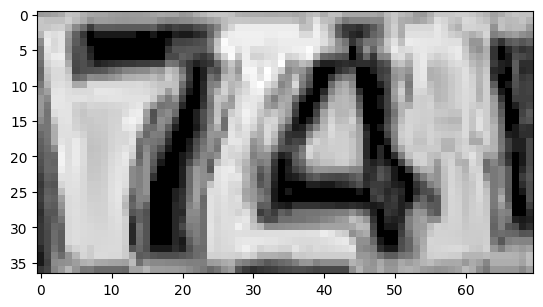

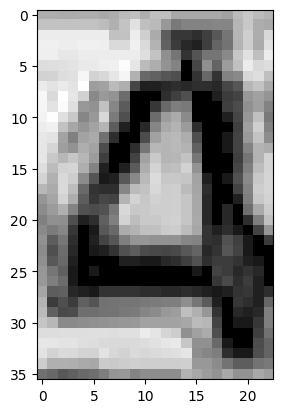

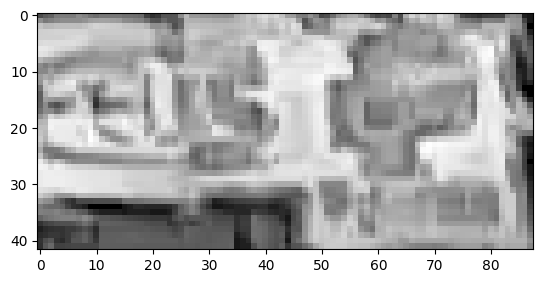

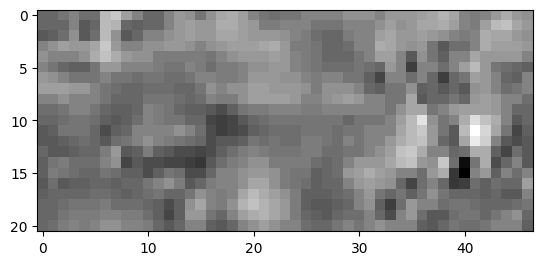

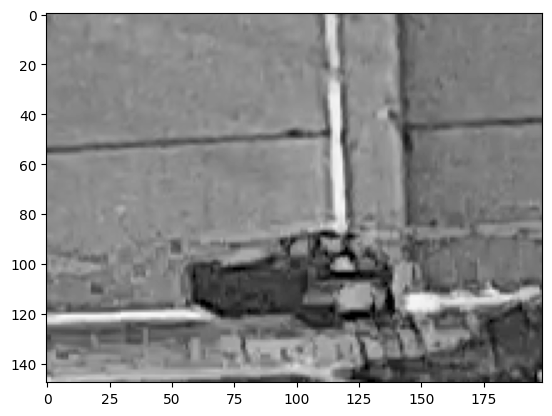

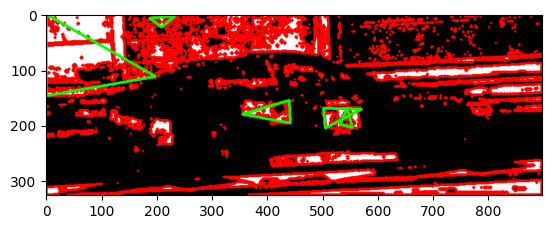

In [8]:
contours = calc_epsilon()

1.6602823734283447


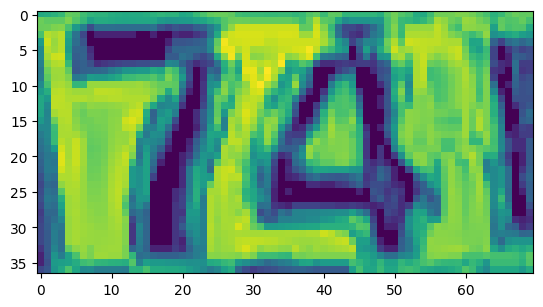

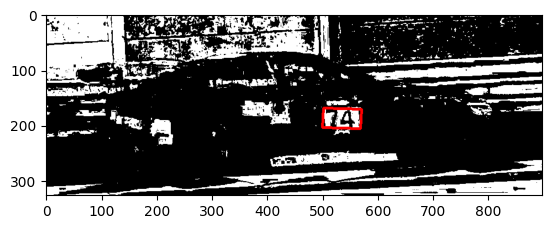

In [9]:
converted = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)

result = None

for contour in contours:
    areaRect = cv2.minAreaRect(contour)
    angle = areaRect[2]

    x, y, w, h = cv2.boundingRect(contour)
    
    if angle < 10:
        print(angle)
        box = cv2.boxPoints(areaRect)
        box = np.intp(box)

        cv2.drawContours(converted, [box], -1, (255, 0, 0), 3)
        
        cut = image[y:y+h, x:x+w]



        (height, width) = cut.shape[:2]


        center = (w // 2, h // 2)
        rotation_mat = cv2.getRotationMatrix2D(center, -angle, 1)
        #result = cv2.warpAffine(cut, rotation_mat, cut.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))



        #result = cv2.resize(result, (width * 2, height * 2))

        result = cut

        plt.imshow(result)
        plt.show()


plt.imshow(converted)
plt.show()



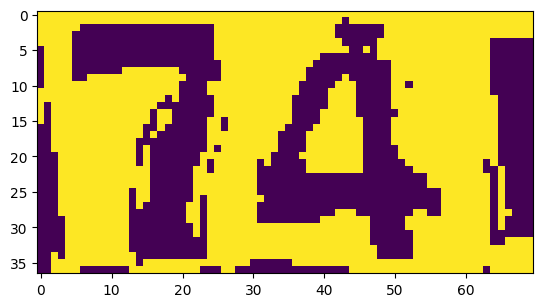

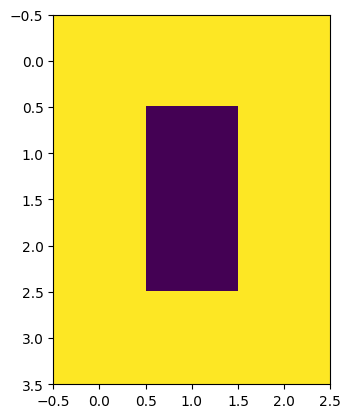

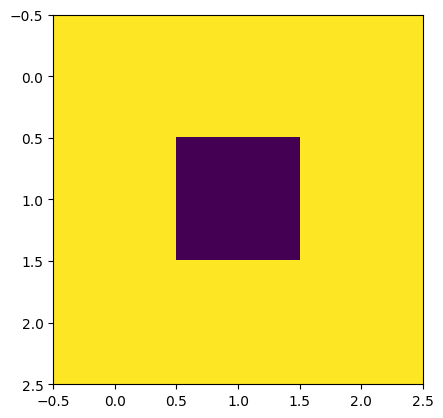

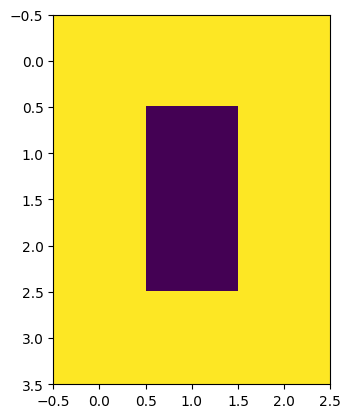

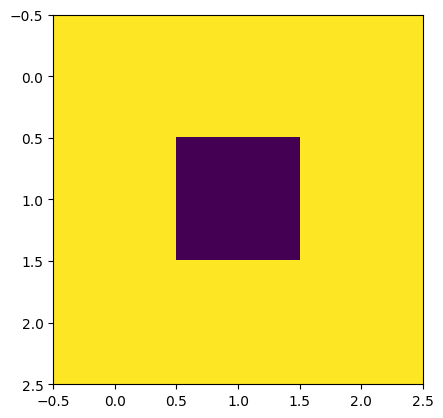

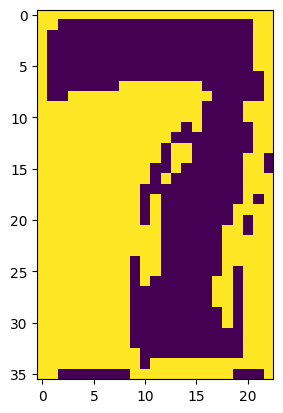

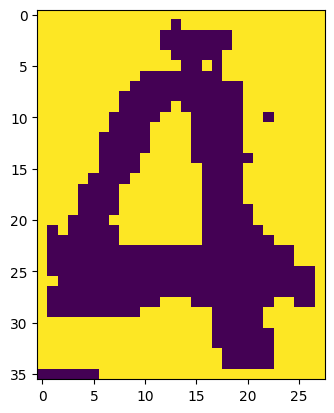

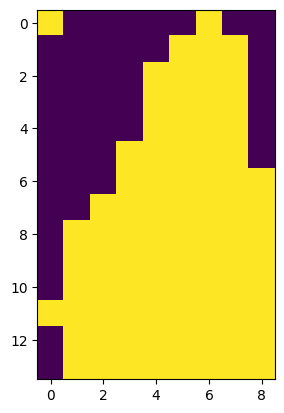

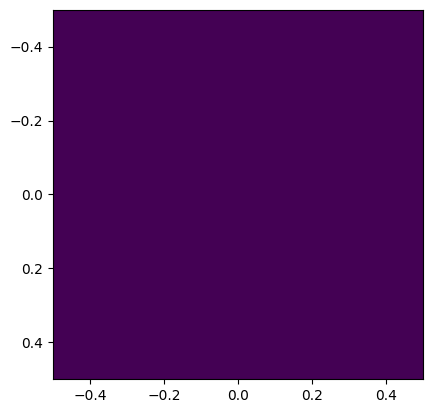

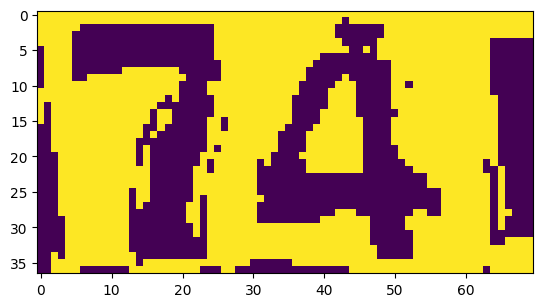

In [10]:

_, otsu_thres  = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU )

contours, _ = cv2.findContours(otsu_thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,)

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    cut = otsu_thres[y:y+h, x:x+w]
    plt.imshow(cut)
    plt.show()

plt.imshow(otsu_thres)
plt.show()

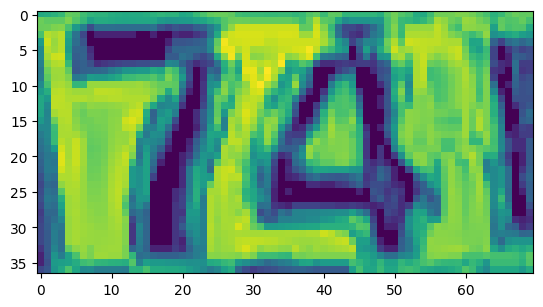

interactive(children=(IntSlider(value=3, description='size', max=15, min=1), IntSlider(value=1, description='i…

<function __main__.change(size=3, it=1)>

In [11]:
plt.imshow(result)
plt.show()

def change(size = 3, it = 1):
    kernel = np.ones((size, size), np.uint8)

    eroded = cv2.erode(result, kernel, iterations=it)

    dilated = cv2.dilate(result, kernel, iterations=it)

    plt.imshow(eroded)
    plt.show()
    plt.imshow(dilated)
    plt.show()

    return eroded, dilated

interact(change, size = IntSlider(value=3, min=1, max=15), it= IntSlider(value=1, min=1, max=4))

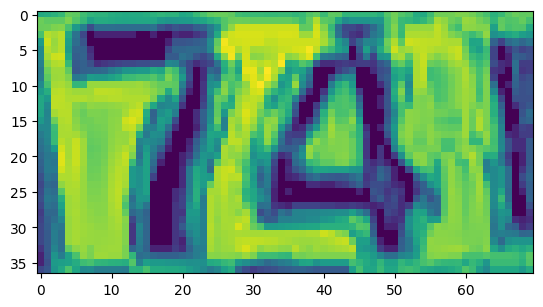

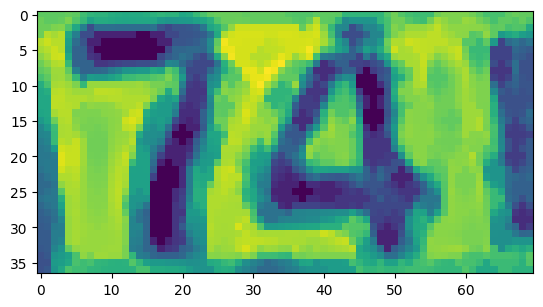

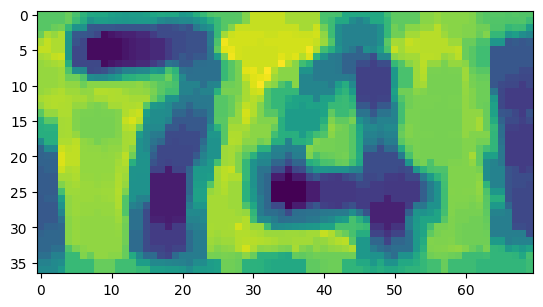

In [12]:

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
morph2 = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel2)


plt.imshow(result)
plt.show()
plt.imshow(morph)
plt.show()
plt.imshow(morph2)
plt.show()

In [13]:


def test_otsu(val):
    _, otsu_thres  = cv2.threshold(result, val, 255, cv2.THRESH_BINARY )
    plt.imshow(otsu_thres, cmap="gray")
    plt.show()

interact(test_otsu, val=IntSlider(min=0, max=255, value=111))

interactive(children=(IntSlider(value=111, description='val', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.test_otsu(val)>

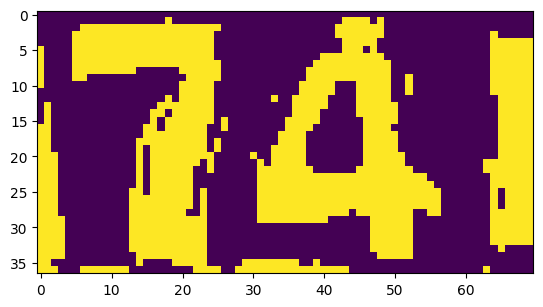

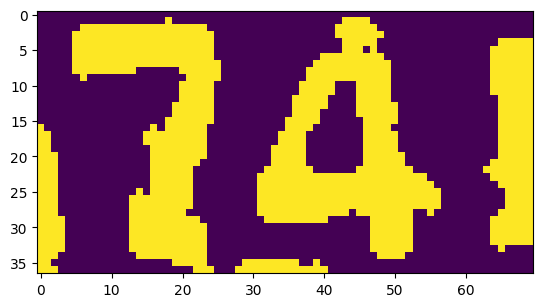

In [14]:
#eroded, dilated = change(3, 1)

_, otsu_thres  = cv2.threshold(result, 111, 255, cv2.THRESH_BINARY )

inv = 255 - otsu_thres

plt.imshow(inv)
plt.show()

closed = cv2.morphologyEx(inv, cv2.MORPH_OPEN, kernel )

plt.imshow(closed)
plt.show()



5
9.0
40.0
124.5
427.5
288.5


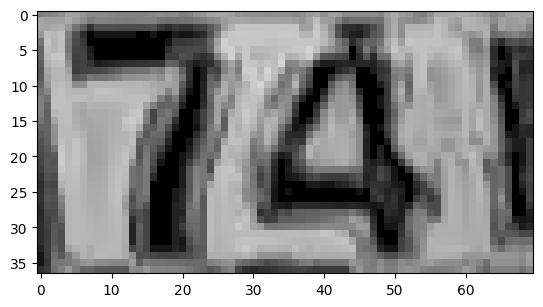

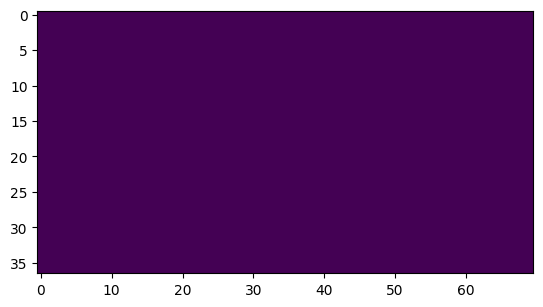

In [15]:
ccopy = closed.copy()
cntrs, _ = cv2.findContours(ccopy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(len(cntrs))
rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

cv2.drawContours(ccopy, cntrs, 0, (0,0,0), -1)

for c in cntrs :
    area = cv2.contourArea(c)
    print(area)
    if area < 1000:
        cv2.drawContours(ccopy, [c], 0, (0,0,0), -1)

plt.imshow(rgb)
plt.show()
plt.imshow(ccopy)
plt.show()

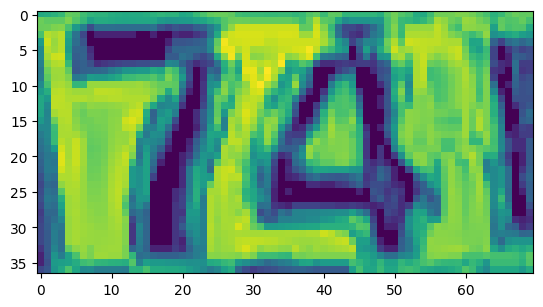

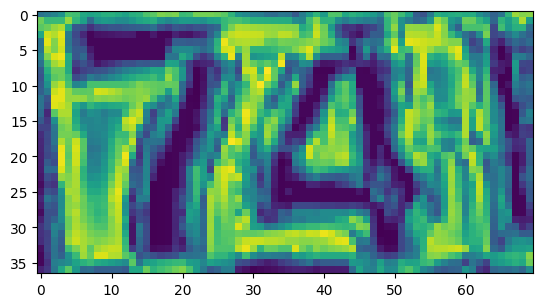

In [16]:
clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(10,10))

boh = clahe.apply(result)
plt.imshow(result)
plt.show()
plt.imshow(boh)
plt.show()

(37, 70)
0
(37, 70, 3)


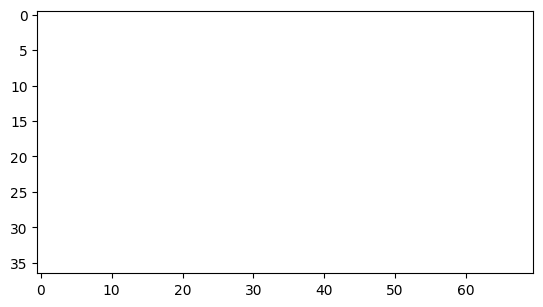

In [17]:
print(ccopy.shape)
print(ccopy[0,0])

maschera = cv2.cvtColor(ccopy, cv2.COLOR_GRAY2RGB)

masked = cv2.bitwise_and(rgb, maschera )

invmask = cv2.bitwise_not(maschera)

masked = cv2.add(masked, invmask)

print(masked.shape)

plt.imshow(masked)
plt.show()

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ...   0 255 255]
 [  0   0   0 ...   0 255 255]]
0.5
2.0
29.5
3.0
12.5
33.5
75.5
21.5
19.0
7.0
5.5
0.0
329.5
0.0
26.5
69.0
61.5
17.5
0.0
1.5
28.5
12.5
2025.5
7396.0


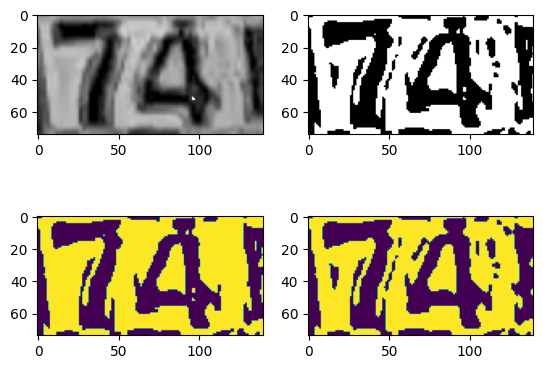

In [18]:
(height, width) = result.shape[:2]
doubled = cv2.resize(result, (width * 2, height * 2))

adaptive = cv2.adaptiveThreshold(doubled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 2)

print(adaptive)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel)
morph2 = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel2)


copy = adaptive.copy()
cntrs, _ = cv2.findContours(- adaptive, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(doubled, cntrs, 0, (255, 255,255), -1)

for c in cntrs :
    area = cv2.contourArea(c)
    print(area)
    if area < 1000:
        cv2.drawContours(copy, [c], 0, 255, -1)


plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(doubled, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 2)
plt.imshow(adaptive, cmap="gray")


plt.subplot(2, 2, 3)
plt.imshow(copy)
plt.subplot(2, 2, 4)
plt.imshow(morph)

plt.show()

In [19]:
import pytesseract
from PIL import Image

filename = "numero.png"
cv2.imwrite(filename, result)
text = pytesseract.image_to_string(Image.open(filename))
print("Text: ", text)

Text:  
